C:\Users\DianaEspinosaLozano\AppData\Local\Temp\ipykernel_10448\1060659751.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  zeit = pd.date_range(start="2014-01-01", end="2014-12-31 23:45", freq="15T")
C:\Users\DianaEspinosaLozano\AppData\Local\Temp\ipykernel_10448\1060659751.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '25.723476080638623' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  lastprofil.at[i, 'Puffer Temp [°C]'] = puffer_temp
C:\Users\DianaEspinosaLozano\AppData\Local\Temp\ipykernel_10448\1060659751.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2523833380109167' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  lastprofil.at[i, 'WP Leistung [kW]'] = wp_elektr

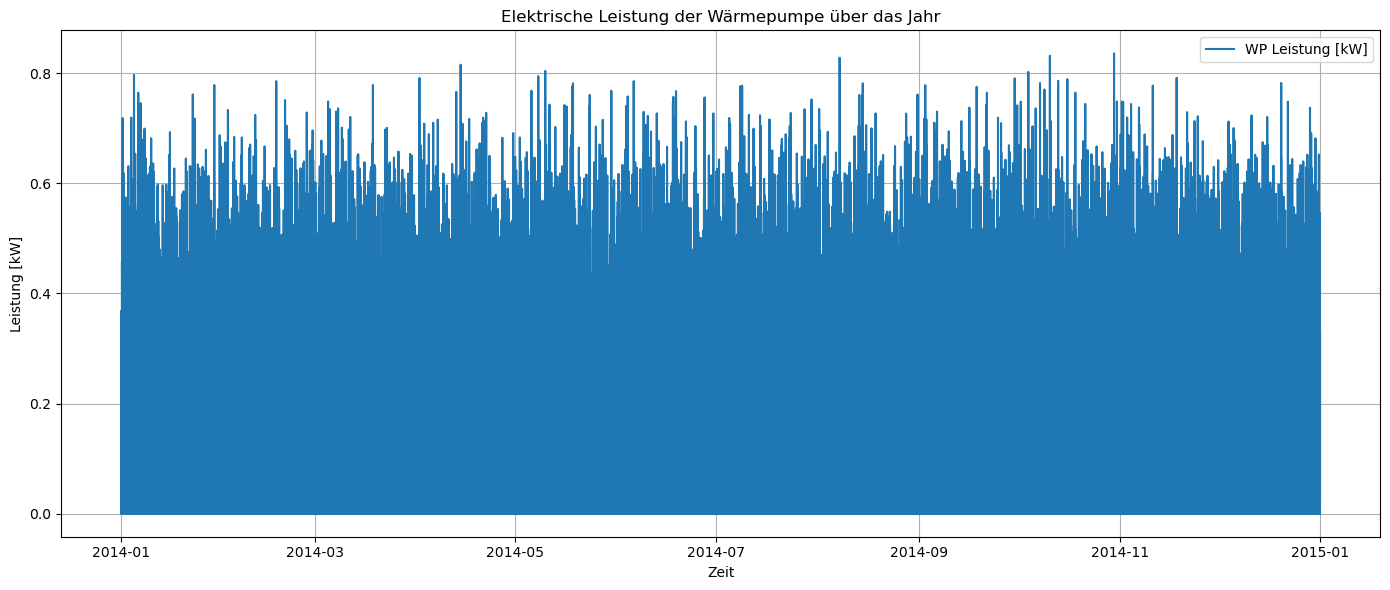

In [1]:
import pandas as pd
import numpy as np

# Grunddaten
wp_leistung = 10  # Heizleistung der WP in kW
puffer_volumen = 200  # Pufferspeicher in Liter
vorlauf_temp = 35  # Vorlauftemperatur in °C
wasser_dichte = 1  # kg/L für Wasser
wasser_wärmekapazität = 4.18  # kJ/kg*K
puffer_kapazität = puffer_volumen * wasser_dichte * wasser_wärmekapazität  # Gesamtkapazität des Puffers in kJ/°C

# Beispiel-COP-Daten (kann mit echten Daten ersetzt werden)
cop_tabelle = pd.DataFrame({
    'Lufttemp': [-7, 2, 7, 12, 20],
    'COP': [2.8, 3.5, 4.0, 4.5, 5.0]
})

# Lastprofil simulieren (Strombedarf & Wärmebedarf)
zeit = pd.date_range(start="2014-01-01", end="2014-12-31 23:45", freq="15T")
lastprofil = pd.DataFrame({
    'Zeit': zeit,
    'Heizwärmebedarf [kWh]': np.random.uniform(0.1, 2.0, len(zeit)),
    'Warmwasserbedarf [kWh]': np.random.uniform(0.0, 0.5, len(zeit)),
    'Außentemperatur [°C]': np.random.uniform(-10, 20, len(zeit))
})

# Initialisiere den Zustand des Puffers
puffer_temp = vorlauf_temp  # Anfangstemperatur
puffer_enthaltene_wärme = puffer_kapazität * puffer_temp / 3600  # in kWh

# Speichere Ergebnisse
lastprofil['WP Leistung [kW]'] = 0  # Elektrische Leistung der WP
lastprofil['Puffer Temp [°C]'] = puffer_temp  # Temperatur des Puffers

for i, row in lastprofil.iterrows():
    # Gesamtwärmebedarf
    wärmebedarf = row['Heizwärmebedarf [kWh]'] + row['Warmwasserbedarf [kWh]']

    # Wärme aus Puffer abdecken
    verfügbare_wärme = min(puffer_enthaltene_wärme, wärmebedarf)
    puffer_enthaltene_wärme -= verfügbare_wärme
    puffer_enthaltene_wärme = max(puffer_enthaltene_wärme, 0)  # Kein negativer Wärmeinhalt

    # Fehlende Wärmebedarf durch WP decken
    fehlende_wärme = wärmebedarf - verfügbare_wärme
    if fehlende_wärme > 0:
        # Interpolation des COP aus der Tabelle
        cop = np.interp(row['Außentemperatur [°C]'], cop_tabelle['Lufttemp'], cop_tabelle['COP'])

        # Berechnung der elektrischen Leistung der WP
        wp_elektrische_leistung = fehlende_wärme / cop
        puffer_enthaltene_wärme += fehlende_wärme  # WP füllt den Puffer wieder auf
    else:
        wp_elektrische_leistung = 0

    # Pufferheizung durch Wärmepumpe
    puffer_temp = (puffer_enthaltene_wärme * 3600) / puffer_kapazität

    # Ergebnisse speichern
    lastprofil.at[i, 'WP Leistung [kW]'] = wp_elektrische_leistung
    lastprofil.at[i, 'Puffer Temp [°C]'] = puffer_temp

import matplotlib.pyplot as plt

# Diagramm für elektrische Leistung
plt.figure(figsize=(14, 6))
plt.plot(lastprofil['Zeit'], lastprofil['WP Leistung [kW]'], label='WP Leistung [kW]')
plt.title('Elektrische Leistung der Wärmepumpe über das Jahr')
plt.xlabel('Zeit')
plt.ylabel('Leistung [kW]')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [2]:
lastprofil

,Zeit,Heizwärmebedarf [kWh],Warmwasserbedarf [kWh],Außentemperatur [°C],WP Leistung [kW],Puffer Temp [°C]
0,2014-01-01 00:00:00,1.926632,0.227583,-9.593108,0.000000,25.723476
1,2014-01-01 00:15:00,0.822885,0.342038,19.440520,0.000000,20.707060
2,2014-01-01 00:30:00,0.516362,0.481485,11.077263,0.000000,16.410111
3,2014-01-01 00:45:00,0.226952,0.393434,-4.066062,0.000000,13.738594
4,2014-01-01 01:00:00,1.801188,0.138810,10.770367,0.000000,5.384535
...,...,...,...,...,...,...
35035,2014-12-31 22:45:00,0.816788,0.182467,16.363192,0.000000,1.095491
35036,2014-12-31 23:00:00,1.501487,0.361732,-0.691301,0.488903,6.927943
35037,2014-12-31 23:15:00,1.359498,0.313620,-5.467909,0.022025,0.276870
35038,2014-12-31 23:30:00,0.366329,0.155004,-6.230833,0.159814,1.968108
